## Import Modules

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Load the Dataset

In [ ]:
df = pd.read_csv('/content/AirPassengers.csv')
df.set_index('Month', inplace=True)
df.head()

,#Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


## Exploratory Data Analysis

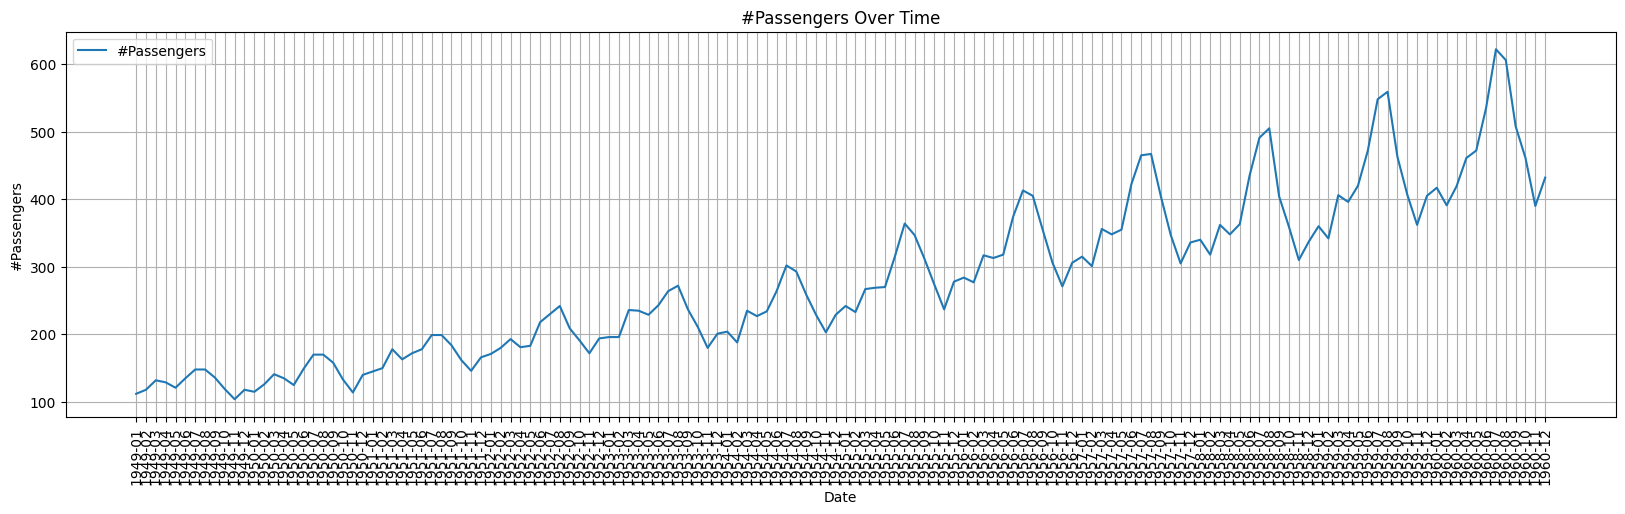

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(df.index, df['#Passengers'], label='#Passengers')
plt.xlabel('Date')
plt.ylabel('#Passengers')
plt.title('#Passengers Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# perform seasonal decomposition
result = seasonal_decompose(df['#Passengers'], model='multiplicative', period=12)

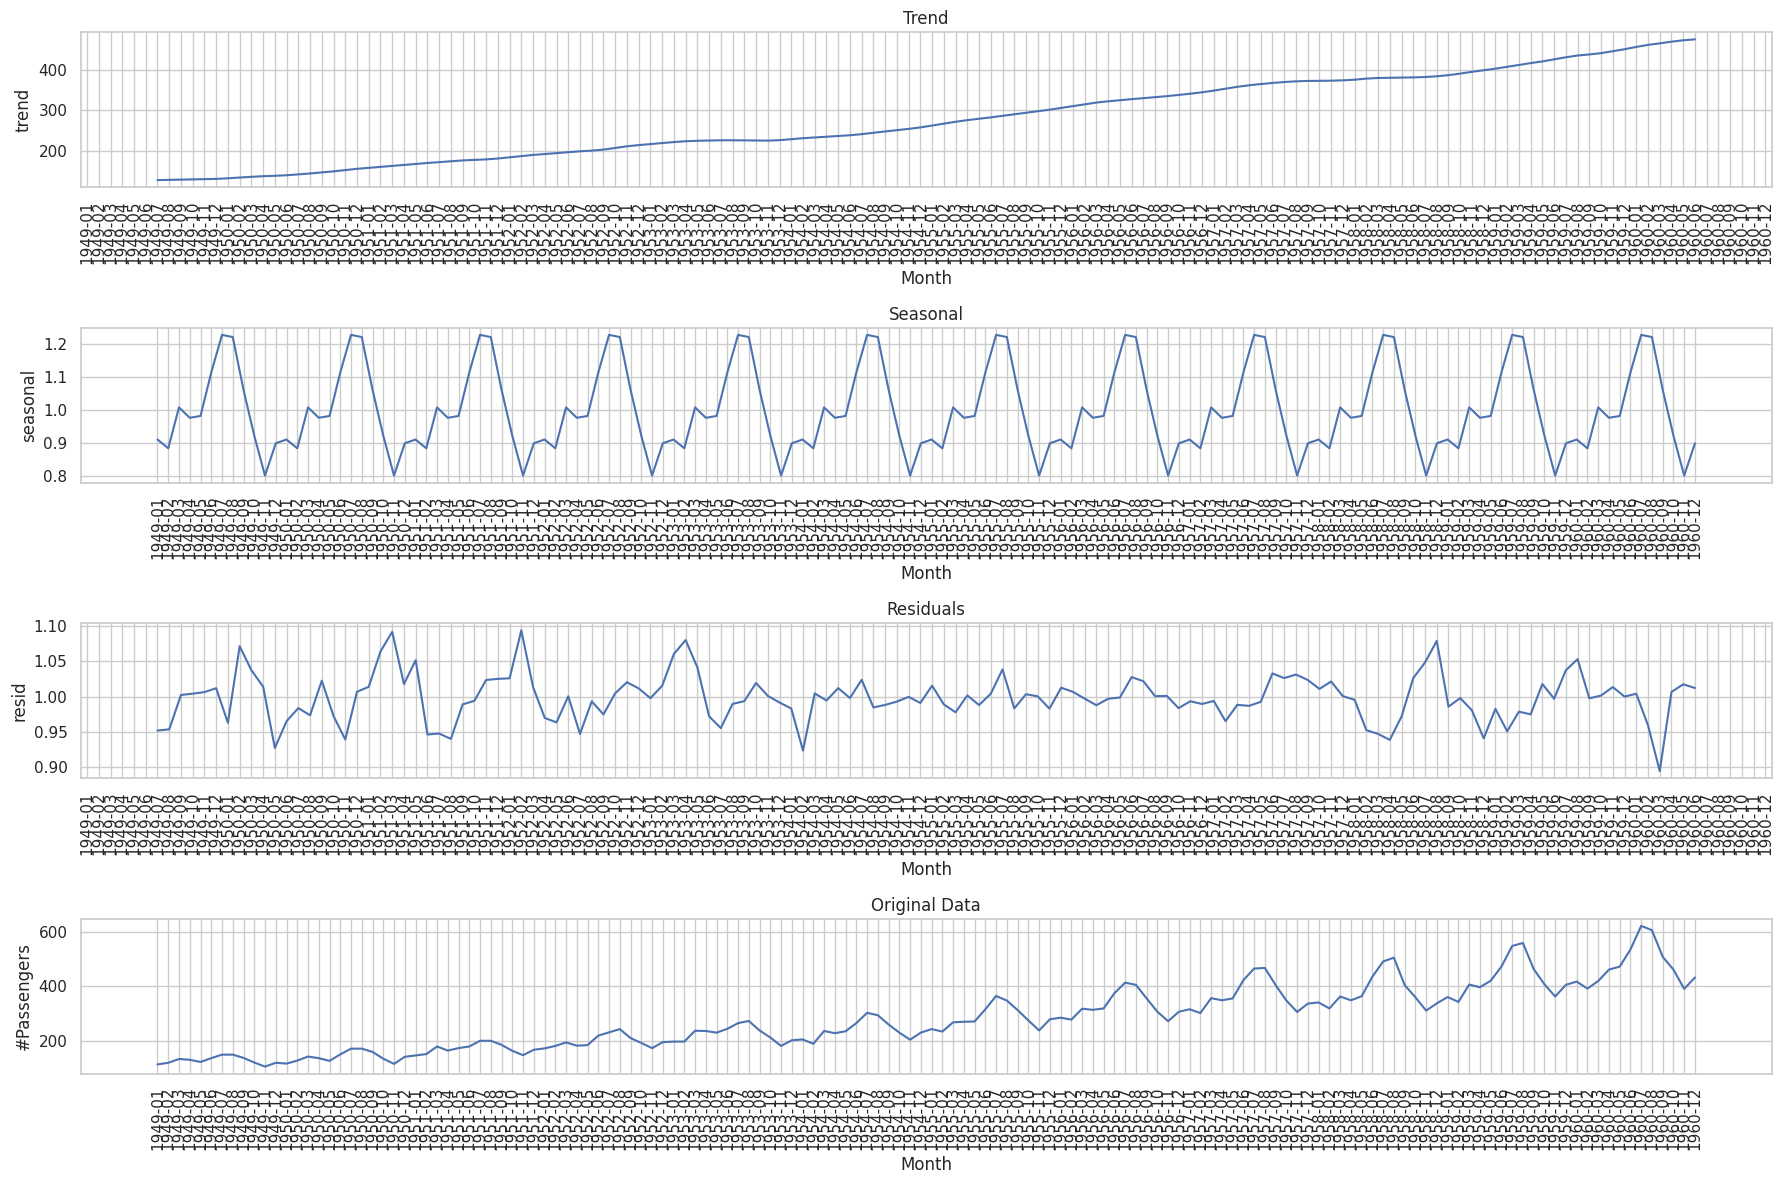

In [ ]:
# plot the components in the graph
sns.set(style='whitegrid')

plt.figure(figsize=(18,12))

# trend component
plt.subplot(411)
sns.lineplot(data=result.trend)
plt.title('Trend')
plt.xticks(rotation=90)

# seasonal component
plt.subplot(412)
sns.lineplot(data=result.seasonal)
plt.title('Seasonal')
plt.xticks(rotation=90)

# Residuals component
plt.subplot(413)
sns.lineplot(data=result.resid)
plt.title('Residuals')
plt.xticks(rotation=90)

# Original data
plt.subplot(414)
sns.lineplot(data=df['#Passengers'])
plt.title('Original Data')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
seasonal_period = 12

In [ ]:
from statsmodels.tsa.stattools import adfuller # Augmented Dickey-Fuller Test

result = adfuller(df['#Passengers'], autolag='AIC') # Akaike Information Criterion
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: 0.8153688792060498
p-value: 0.991880243437641


In [ ]:
# first order differencing
result = adfuller(df['#Passengers'].diff().dropna(), autolag='AIC')
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -2.8292668241700047
p-value: 0.05421329028382478


In [ ]:
# second order differencing
result = adfuller(df['#Passengers'].diff().diff().dropna(), autolag='AIC')
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -16.384231542468513
p-value: 2.7328918500142026e-29


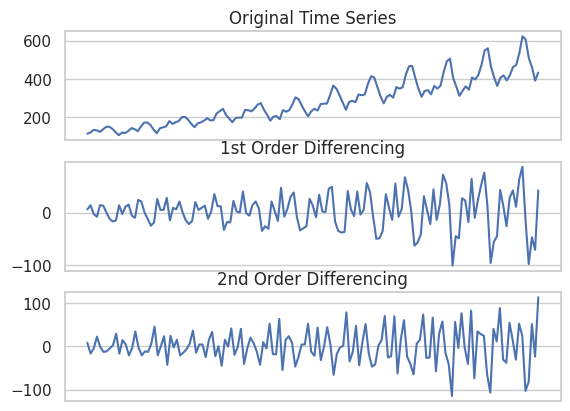

In [ ]:
# plot the differencing values
fig, (ax1, ax2, ax3) = plt.subplots(3)

ax1.plot(df)
ax1.set_title('Original Time Series')
ax1.axes.xaxis.set_visible(False)

ax2.plot(df.diff())
ax2.set_title('1st Order Differencing')
ax2.axes.xaxis.set_visible(False)

ax3.plot(df.diff().diff())
ax3.set_title('2nd Order Differencing')
ax3.axes.xaxis.set_visible(False)

plt.show()

In [ ]:
# the time series becomes stationary after first order differencing

## Define Parameters for ARIMA

In [ ]:
# p = 0 # MA - Moving Average - PACF
# d = 1 # order of differencing - I
# q = 0 # AR - Auto Regressive - ACF

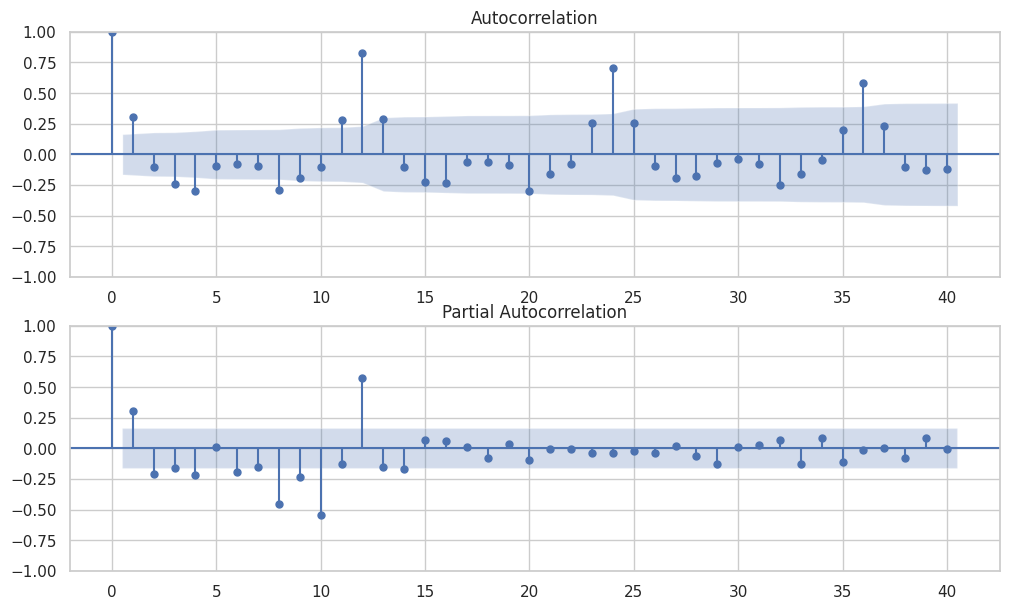

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 7))
sm.graphics.tsa.plot_acf(df.diff().dropna(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(df.diff().dropna(), lags=40, ax=ax[1])
plt.show()

In [ ]:
p = 2 # pacf
d = 1 # 1st order difference
q = 1 # acf

In [ ]:
P = 1
D = 0
Q = 3

## Model Training

In [ ]:
# define the arima model
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df['#Passengers'], order=(p, d, q), seasonal_order=(P, D, Q, seasonal_period))
fitted_model = model.fit()
print(fitted_model.summary())

                                         SARIMAX Results                                          
Dep. Variable:                                #Passengers   No. Observations:                  144
Model:             SARIMAX(2, 1, 1)x(1, 0, [1, 2, 3], 12)   Log Likelihood                -563.224
Date:                                    Mon, 28 Apr 2025   AIC                           1142.448
Time:                                            04:59:45   BIC                           1166.151
Sample:                                        01-01-1949   HQIC                          1152.080
                                             - 12-01-1960                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6249      0.101      6.170      0

## Forecasting

In [ ]:
# forecast for next 2 years
forecast_steps = 24
forecast = fitted_model.get_forecast(steps=forecast_steps)

# create the date range for the forecasted values
forecast_index = pd.date_range(start=df.index[-1], periods=forecast_steps+1, freq='M')[1:].strftime('%Y-%m') # remove start date

In [ ]:
# create a forecast dataframe
forecast_df = pd.DataFrame({
    "Forecast": list(forecast.predicted_mean),
    "Lower CI": list(forecast.conf_int().iloc[:, 0]),
    "Upper CI": list(forecast.conf_int().iloc[:, 1])
}, index=forecast_index)

forecast_df.head()

,Forecast,Lower CI,Upper CI
1961-01,446.738093,424.895543,468.580642
1961-02,423.372538,397.233536,449.511540
1961-03,456.502830,426.884948,486.120712
1961-04,491.641818,459.608451,523.675186
1961-05,505.210954,471.327872,539.094037


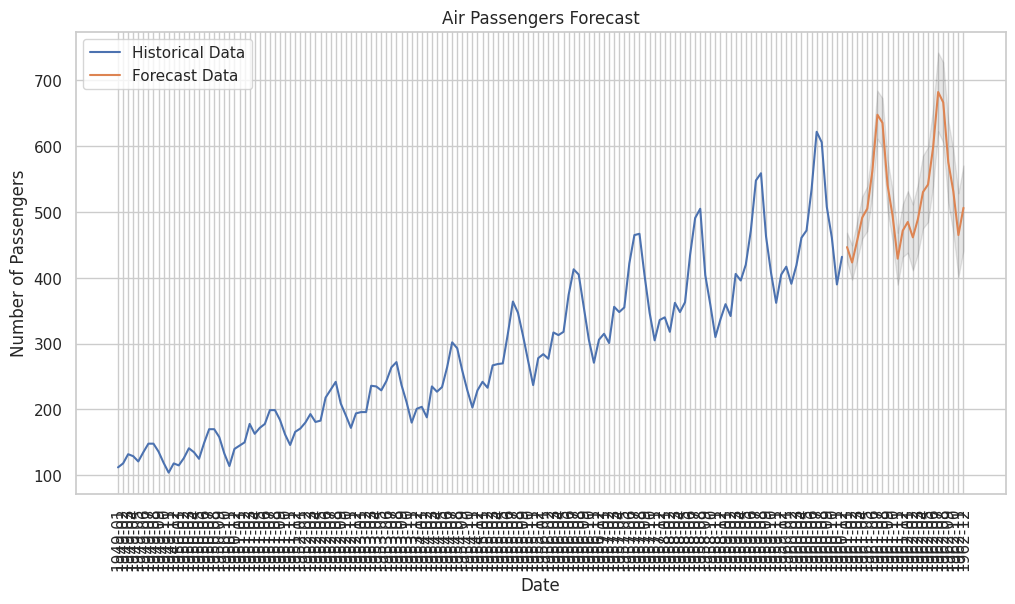

In [ ]:
# plot the forecast values

plt.figure(figsize=(12, 6))
plt.plot(df['#Passengers'], label='Historical Data')
plt.plot(forecast_df['Forecast'], label='Forecast Data')
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], color='k', alpha=0.1)
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.title('Air Passengers Forecast')
plt.xticks(rotation=90)
plt.legend()
plt.show()